In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/UTKFace.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [3]:
import os
import shutil

# Chemin vers le dossier UTKFace
utkface_folder = "/content/UTKFace"

# Créer un dossier de sortie
output_folder = "/content/UTKFaceN"
os.makedirs(output_folder, exist_ok=True)

# Définir les âges pour lesquels vous voulez collecter des images
ages_to_collect = list(range(1, 101))

# Nombre d'images à collecter par âge
images_per_age = 45

# Parcourir tous les fichiers dans le dossier UTKFace
for filename in os.listdir(utkface_folder):
    # Extraire l'âge du nom de fichier
    age = int(filename.split('_')[0])

    # Vérifier si l'âge est dans la liste des âges à collecter
    if age in ages_to_collect:
        # Copier le fichier dans le dossier UTKFaceM
        source_path = os.path.join(utkface_folder, filename)
        destination_path = os.path.join(output_folder, filename)
        shutil.copyfile(source_path, destination_path)

        # Décrémenter le nombre d'images à collecter pour cet âge
        images_per_age -= 1

        # Vérifier si vous avez collecté suffisamment d'images pour cet âge
        if images_per_age == 0:
            ages_to_collect.remove(age)
            images_per_age = 40  # Réinitialiser le nombre d'images à collecter pour le prochain âge

        if not ages_to_collect:
            break


In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Explorer la structure du jeu de données
data_path = "/content/UTKFaceN"
images = []
labels = []

for filename in os.listdir(data_path):
    if filename.endswith(".jpg"):
        # Les noms de fichiers dans UTKFace sont formatés comme "âge_genre_date_heure_minute_seconde.jpg"
        age = int(filename.split('_')[0])
        labels.append(age)
        img_path = os.path.join(data_path, filename)
        img = cv2.imread(img_path)
        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        # Ajout de prétraitements pour réduire le bruit
        img = cv2.resize(img, (224, 224))  # Redimensionner les images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir l'image en format RGB
        #img = cv2.GaussianBlur(img, (3, 3), 0)  # Appliquer un filtre de Gauss pour le lissage

        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        images.append(img)

# Convertir les listes en tableaux NumPy
images = np.array(images)
labels = np.array(labels)

# 2. Diviser le jeu de données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Normaliser les images (mise à l'échelle des pixels entre 0 et 1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0




In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import cv2

# Charger InceptionV3 pré-entraîné sans les couches fully connected
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = True

# Créer un modèle séquentiel
model = models.Sequential()

# Ajouter InceptionV3 comme couche de base
model.add(base_model)

# Ajouter des couches supplémentaires pour la détection de l'âge
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='linear', name='age'))

# Compiler le modèle
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Afficher le résumé du modèle
print(model.summary())

87910968/87910968 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 age (Dense)                 (None, 1)                 513       
                                                                 
Total params: 22852385 (87.17 MB)
Trainable params: 22817

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=70, shuffle = True)

Epoch 1/70
72/72 [==============================] - 77s 379ms/step - loss: 366.5713 - mae: 14.0665 - val_loss: 184577104.0000 - val_mae: 4026.6528
Epoch 2/70
72/72 [==============================] - 18s 246ms/step - loss: 208.7690 - mae: 11.1792 - val_loss: 6750922.0000 - val_mae: 1996.1086
Epoch 3/70
72/72 [==============================] - 17s 243ms/step - loss: 164.3139 - mae: 9.7148 - val_loss: 128798.3047 - val_mae: 248.7195
Epoch 4/70
72/72 [==============================] - 18s 245ms/step - loss: 131.0747 - mae: 8.6474 - val_loss: 252.9190 - val_mae: 11.7586
Epoch 5/70
72/72 [==============================] - 18s 250ms/step - loss: 113.1739 - mae: 8.1792 - val_loss: 157.6280 - val_mae: 9.4502
Epoch 6/70
72/72 [==============================] - 18s 252ms/step - loss: 106.1400 - mae: 7.8922 - val_loss: 119.5603 - val_mae: 8.2561
Epoch 7/70
72/72 [==============================] - 18s 255ms/step - loss: 110.5651 - mae: 8.1409 - val_loss: 488.6390 - val_mae: 17.4918
Epoch 8/70
72/72

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

16/16 [==============================] - 1s 77ms/step - loss: 191.2778 - mae: 10.5256
Test Loss: 191.27784729003906, Test MAE: 10.525561332702637


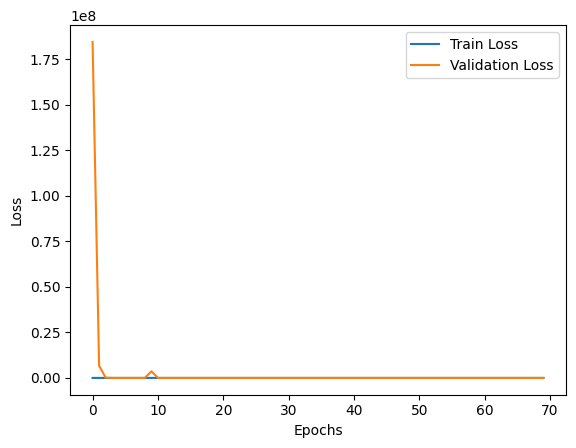

In [ ]:
import matplotlib.pyplot as plt

# Afficher les courbes d'apprentissage
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)
# Afficher les vrais âges et les prédictions sous forme de tableau
comparison_table = np.column_stack((y_test, predictions.flatten()))
print("Vrais Âges vs Prédictions d'Âge :\n", comparison_table)

16/16 [==============================] - 2s 72ms/step
Vrais Âges vs Prédictions d'Âge :
 [[ 37.          40.69132233]
 [ 37.          61.01105118]
 [ 76.          69.49209595]
 [ 42.          65.94004059]
 [ 73.          63.50403976]
 [ 26.          34.00829315]
 [ 44.          70.45321655]
 [ 85.          84.5752182 ]
 [  1.           6.68339539]
 [ 64.          70.42971039]
 [ 10.          59.9432869 ]
 [ 19.          29.85740089]
 [ 76.          54.68704987]
 [ 31.          44.32617188]
 [ 79.          70.75988007]
 [ 89.          71.87942505]
 [ 48.          67.56083679]
 [ 30.          29.43153   ]
 [ 66.          81.09389496]
 [ 32.          44.53102875]
 [ 11.          15.90588474]
 [ 43.          61.79616928]
 [  9.          18.96084785]
 [ 15.          21.86158371]
 [  4.          16.65465546]
 [ 15.          17.38698769]
 [  4.          19.8728981 ]
 [ 48.          54.57951355]
 [ 75.          73.04050446]
 [ 89.          74.06802368]
 [ 64.          74.56877899]
 [ 38.      

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcul des métriques
mae = mean_absolute_error(y_test, predictions.flatten())
mse = mean_squared_error(y_test, predictions.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions.flatten())

# Affichage des résultats
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

MAE: 10.53
MSE: 191.28
RMSE: 13.83
R^2: 0.72


In [ ]:
tolerance = 10  # La fourchette acceptable autour de l'âge réel

# Calculer la précision
correct_predictions = np.sum(np.abs(y_test - predictions.flatten()) <= tolerance)
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions

# Afficher la précision
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 59.84%


In [5]:
import tensorflow as tf

# Chargement d'un modèle pré-entraîné
modelInception = tf.keras.models.load_model('/content/drive/MyDrive/CV/Inception.h5')

1/1 [==============================] - 0s 34ms/step


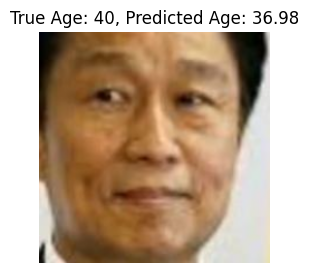

In [13]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt


  # Redimensionner l'image pour qu'elle ait la forme attendue
resized_image = tf.image.resize(X_test[8], (224, 224))
resized_image = np.expand_dims(resized_image, axis=0)  # Ajouter la dimension de lot

plt.figure(figsize=(3, 3))  # Nouvelle taille de figure
plt.imshow(X_test[8])
true_age = y_test[8]

    # Faire la prédiction avec l'image redimensionnée
prediction = modelInception.predict(resized_image)
predicted_age = prediction[0, 0]

plt.title(f'True Age: {true_age}, Predicted Age: {predicted_age:.2f}')
plt.axis('off')
plt.show()